# Reading general data of the problems


In [6]:
# coding=utf-8
from __future__ import division
import json
import os
import sys

from MyUtils import clean_folder, read_files
from Word2Dim import Word2Dim

dataset_path = '.' + os.sep + 'pan19-cross-domain-authorship-attribution-training-dataset-2019-01-23'
outpath = '.' + os.sep + 'dev_out'

clean_folder(outpath)

infocollection = dataset_path + os.sep + 'collection-info.json'
problems = []
language = []
with open(infocollection, 'r') as f:
    for attrib in json.load(f):
        problems.append(attrib['problem-name'])
        language.append(attrib['language'])
print('Reading general data of the problems, done!')


Reading general data of the problems, done!


# Reading problem 1

In [7]:


%%notify
problem = problems[0]
index = 0
infoproblem = dataset_path + os.sep + problem + os.sep + 'problem-info.json'
candidates = []
with open(infoproblem, 'r') as f:
    fj = json.load(f)
    unk_folder = fj['unknown-folder']
    for attrib in fj['candidate-authors']:
        candidates.append(attrib['author-name'])

candidates.sort()
# Building training set
train_docs = []
for candidate in candidates:
    train_docs.extend(read_files(dataset_path + os.sep + problem, candidate))
train_texts = [text for i, (text, label) in enumerate(train_docs)]
train_labels = [label for i, (text, label) in enumerate(train_docs)]
index_2_label_dict = {i: l for i, l in enumerate(set(train_labels))}
label_2_index_dict = {l: i for i, l in enumerate(set(train_labels))}
train_labels = [label_2_index_dict[v] for v in train_labels]
w2d = Word2Dim()
train_tokenized_with_pos, train_tokenized_indexed = w2d.fit_transform_texts(train_texts, train_labels,
                                                                            language[index])

maxlen = len(max(train_tokenized_indexed, key=len))  # We will cut the texts after # words
embedding_dim = w2d.word_embedding.shape[1]

# preparing test set
ground_truth_file = dataset_path + os.sep + problem + os.sep + 'ground-truth.json'
gt = {}
with open(ground_truth_file, 'r') as f:
    for attrib in json.load(f)['ground_truth']:
        gt[attrib['unknown-text']] = attrib['true-author']

test_docs = read_files(dataset_path + os.sep + problem, unk_folder, gt)
test_texts = [text for i, (text, label) in enumerate(test_docs)]
test_labels = [label for i, (text, label) in enumerate(test_docs)]

# Filter validation to known authors
test_texts = [text for i, (text, label) in enumerate(test_docs) if label in label_2_index_dict.keys()]
test_labels = [label for i, (text, label) in enumerate(test_docs) if label in label_2_index_dict.keys()]

test_labels = [label_2_index_dict[v] for v in test_labels]

test_tokenized_with_pos, test_tokenized_indexed = w2d.transform(test_texts)
print("Reading problem 1, done!")

doc count to process:  63
process_doc, done!
doc count to process:  468
Reading problem 1, done!


<IPython.core.display.Javascript object>

# Keras Stuff


In [ ]:
[index_2_label_dict[test_label] for test_label in test_labels]


y: (?, 1020, 32) x: (?, 1020, 32)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
words (InputLayer)              (None, 1020)         0                                            
__________________________________________________________________________________________________
embedding_30 (Embedding)        (None, 1020, 9)      68607       words[0][0]                      
__________________________________________________________________________________________________
conv1d_57 (Conv1D)              (None, 1020, 32)     608         embedding_30[0][0]               
__________________________________________________________________________________________________
conv1d_58 (Conv1D)              (None, 1020, 32)     3104        conv1d_57[0][0]                  
___________________________________________________________________________

Epoch 48/500
54/54 [==============================] - 0s 5ms/step - loss: 1.9306 - acc: 0.6296 - val_loss: 2.1280 - val_acc: 0.2222
Epoch 49/500
54/54 [==============================] - 0s 6ms/step - loss: 1.9221 - acc: 0.6296 - val_loss: 2.1254 - val_acc: 0.2222
Epoch 50/500
54/54 [==============================] - 0s 6ms/step - loss: 1.9117 - acc: 0.6296 - val_loss: 2.1219 - val_acc: 0.2222
Epoch 51/500
54/54 [==============================] - 0s 6ms/step - loss: 1.9025 - acc: 0.6296 - val_loss: 2.1193 - val_acc: 0.2222
Epoch 52/500
54/54 [==============================] - 0s 6ms/step - loss: 1.8932 - acc: 0.6296 - val_loss: 2.1158 - val_acc: 0.2222
Epoch 53/500
54/54 [==============================] - 0s 6ms/step - loss: 1.8818 - acc: 0.6296 - val_loss: 2.1126 - val_acc: 0.2222
Epoch 54/500
54/54 [==============================] - 0s 5ms/step - loss: 1.8713 - acc: 0.6667 - val_loss: 2.1091 - val_acc: 0.2222
Epoch 55/500
54/54 [==============================] - 0s 6ms/step - loss: 1.

Epoch 110/500
54/54 [==============================] - 0s 6ms/step - loss: 0.8386 - acc: 1.0000 - val_loss: 1.7598 - val_acc: 0.5556
Epoch 111/500
54/54 [==============================] - 0s 6ms/step - loss: 0.8179 - acc: 1.0000 - val_loss: 1.7552 - val_acc: 0.5556
Epoch 112/500
54/54 [==============================] - 0s 6ms/step - loss: 0.7969 - acc: 1.0000 - val_loss: 1.7463 - val_acc: 0.5556
Epoch 113/500
54/54 [==============================] - 0s 5ms/step - loss: 0.7761 - acc: 1.0000 - val_loss: 1.7380 - val_acc: 0.5556
Epoch 114/500
54/54 [==============================] - 0s 6ms/step - loss: 0.7559 - acc: 1.0000 - val_loss: 1.7300 - val_acc: 0.5556
Epoch 115/500
54/54 [==============================] - 0s 6ms/step - loss: 0.7367 - acc: 1.0000 - val_loss: 1.7225 - val_acc: 0.5556
Epoch 116/500
54/54 [==============================] - 0s 6ms/step - loss: 0.7160 - acc: 1.0000 - val_loss: 1.7162 - val_acc: 0.5556
Epoch 117/500
54/54 [==============================] - 0s 6ms/step - 

54/54 [==============================] - 0s 5ms/step - loss: 0.1115 - acc: 1.0000 - val_loss: 1.4274 - val_acc: 0.4444
Epoch 172/500
54/54 [==============================] - 0s 5ms/step - loss: 0.1075 - acc: 1.0000 - val_loss: 1.4253 - val_acc: 0.4444
Epoch 173/500
54/54 [==============================] - ETA: 0s - loss: 0.1026 - acc: 1.000 - 0s 5ms/step - loss: 0.1036 - acc: 1.0000 - val_loss: 1.4207 - val_acc: 0.4444
Epoch 174/500
54/54 [==============================] - 0s 6ms/step - loss: 0.1000 - acc: 1.0000 - val_loss: 1.4184 - val_acc: 0.4444
Epoch 175/500
54/54 [==============================] - 0s 6ms/step - loss: 0.0964 - acc: 1.0000 - val_loss: 1.4145 - val_acc: 0.4444
Epoch 176/500
54/54 [==============================] - 0s 6ms/step - loss: 0.0932 - acc: 1.0000 - val_loss: 1.4123 - val_acc: 0.4444
Epoch 177/500
54/54 [==============================] - 0s 6ms/step - loss: 0.0902 - acc: 1.0000 - val_loss: 1.4101 - val_acc: 0.4444
Epoch 178/500
54/54 [========================

54/54 [==============================] - 0s 5ms/step - loss: 0.0141 - acc: 1.0000 - val_loss: 1.3208 - val_acc: 0.4444
Epoch 233/500
54/54 [==============================] - 0s 6ms/step - loss: 0.0136 - acc: 1.0000 - val_loss: 1.3191 - val_acc: 0.4444
Epoch 234/500
54/54 [==============================] - 0s 6ms/step - loss: 0.0132 - acc: 1.0000 - val_loss: 1.3184 - val_acc: 0.4444
Epoch 235/500
54/54 [==============================] - 0s 6ms/step - loss: 0.0128 - acc: 1.0000 - val_loss: 1.3187 - val_acc: 0.4444
Epoch 236/500
54/54 [==============================] - 0s 6ms/step - loss: 0.0124 - acc: 1.0000 - val_loss: 1.3188 - val_acc: 0.4444
Epoch 237/500
54/54 [==============================] - 0s 6ms/step - loss: 0.0120 - acc: 1.0000 - val_loss: 1.3179 - val_acc: 0.4444
Epoch 238/500
54/54 [==============================] - 0s 5ms/step - loss: 0.0116 - acc: 1.0000 - val_loss: 1.3175 - val_acc: 0.4444
Epoch 239/500
54/54 [==============================] - 0s 5ms/step - loss: 0.0112 -

Epoch 294/500
54/54 [==============================] - 0s 6ms/step - loss: 0.0020 - acc: 1.0000 - val_loss: 1.3109 - val_acc: 0.4444
Epoch 295/500
54/54 [==============================] - 0s 6ms/step - loss: 0.0019 - acc: 1.0000 - val_loss: 1.3110 - val_acc: 0.4444
Epoch 296/500
54/54 [==============================] - 0s 6ms/step - loss: 0.0019 - acc: 1.0000 - val_loss: 1.3118 - val_acc: 0.4444
Epoch 297/500
54/54 [==============================] - 0s 5ms/step - loss: 0.0018 - acc: 1.0000 - val_loss: 1.3094 - val_acc: 0.4444
Epoch 298/500
54/54 [==============================] - 0s 6ms/step - loss: 0.0018 - acc: 1.0000 - val_loss: 1.3119 - val_acc: 0.4444
Epoch 299/500
54/54 [==============================] - 0s 5ms/step - loss: 0.0017 - acc: 1.0000 - val_loss: 1.3107 - val_acc: 0.4444
Epoch 300/500
54/54 [==============================] - 0s 6ms/step - loss: 0.0017 - acc: 1.0000 - val_loss: 1.3132 - val_acc: 0.4444
Epoch 301/500
54/54 [==============================] - 0s 6ms/step - 

54/54 [==============================] - 0s 6ms/step - loss: 3.1735e-04 - acc: 1.0000 - val_loss: 1.3493 - val_acc: 0.4444
Epoch 355/500
54/54 [==============================] - 0s 6ms/step - loss: 3.0826e-04 - acc: 1.0000 - val_loss: 1.3511 - val_acc: 0.4444
Epoch 356/500
54/54 [==============================] - 0s 5ms/step - loss: 2.9876e-04 - acc: 1.0000 - val_loss: 1.3520 - val_acc: 0.4444
Epoch 357/500
54/54 [==============================] - 0s 6ms/step - loss: 2.9016e-04 - acc: 1.0000 - val_loss: 1.3537 - val_acc: 0.4444
Epoch 358/500
54/54 [==============================] - 0s 6ms/step - loss: 2.8186e-04 - acc: 1.0000 - val_loss: 1.3528 - val_acc: 0.4444
Epoch 359/500
54/54 [==============================] - 0s 6ms/step - loss: 2.7323e-04 - acc: 1.0000 - val_loss: 1.3546 - val_acc: 0.4444
Epoch 360/500
54/54 [==============================] - 0s 6ms/step - loss: 2.6499e-04 - acc: 1.0000 - val_loss: 1.3565 - val_acc: 0.4444
Epoch 361/500
54/54 [==============================] - 

Epoch 414/500
54/54 [==============================] - 0s 6ms/step - loss: 5.2804e-05 - acc: 1.0000 - val_loss: 1.4180 - val_acc: 0.4444
Epoch 415/500
54/54 [==============================] - 0s 6ms/step - loss: 5.1306e-05 - acc: 1.0000 - val_loss: 1.4197 - val_acc: 0.4444
Epoch 416/500
54/54 [==============================] - 0s 5ms/step - loss: 4.9745e-05 - acc: 1.0000 - val_loss: 1.4216 - val_acc: 0.4444
Epoch 417/500
54/54 [==============================] - 0s 6ms/step - loss: 4.8222e-05 - acc: 1.0000 - val_loss: 1.4247 - val_acc: 0.4444
Epoch 418/500
54/54 [==============================] - 0s 6ms/step - loss: 4.6926e-05 - acc: 1.0000 - val_loss: 1.4219 - val_acc: 0.4444
Epoch 419/500
54/54 [==============================] - 0s 6ms/step - loss: 4.5566e-05 - acc: 1.0000 - val_loss: 1.4278 - val_acc: 0.4444
Epoch 420/500
54/54 [==============================] - 0s 5ms/step - loss: 4.4210e-05 - acc: 1.0000 - val_loss: 1.4274 - val_acc: 0.4444
Epoch 421/500
54/54 [====================

Epoch 474/500
54/54 [==============================] - 0s 5ms/step - loss: 8.9562e-06 - acc: 1.0000 - val_loss: 1.5156 - val_acc: 0.4444
Epoch 475/500
54/54 [==============================] - 0s 6ms/step - loss: 8.6990e-06 - acc: 1.0000 - val_loss: 1.5205 - val_acc: 0.4444
Epoch 476/500
54/54 [==============================] - 0s 6ms/step - loss: 8.4518e-06 - acc: 1.0000 - val_loss: 1.5193 - val_acc: 0.4444
Epoch 477/500
54/54 [==============================] - 0s 6ms/step - loss: 8.1957e-06 - acc: 1.0000 - val_loss: 1.5227 - val_acc: 0.4444
Epoch 478/500
54/54 [==============================] - 0s 6ms/step - loss: 7.9882e-06 - acc: 1.0000 - val_loss: 1.5264 - val_acc: 0.4444
Epoch 479/500
54/54 [==============================] - 0s 6ms/step - loss: 7.7221e-06 - acc: 1.0000 - val_loss: 1.5263 - val_acc: 0.4444
Epoch 480/500
54/54 [==============================] - 0s 6ms/step - loss: 7.5102e-06 - acc: 1.0000 - val_loss: 1.5267 - val_acc: 0.4444
Epoch 481/500
54/54 [====================

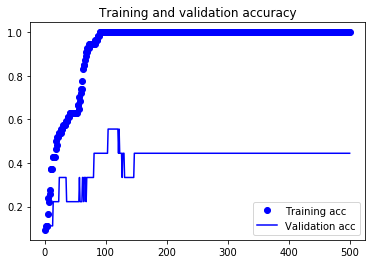

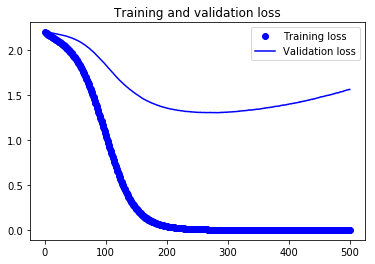

In [36]:
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(1)


from keras import layers, Input
from keras.models import Sequential, Model
from keras import optimizers
from keras.utils import to_categorical
from keras_preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split



train_data = pad_sequences(train_tokenized_indexed, maxlen=maxlen)

test_data = pad_sequences(test_tokenized_indexed, maxlen=maxlen)

# X_train, X_val, y_train, y_val = train_data, test_data, to_categorical(train_labels), to_categorical(test_labels)
X_train, X_val, y_train, y_val = train_test_split(train_data, train_labels,
                                                  test_size=len(set(train_labels)), random_state=2019,
                                                  stratify=train_labels)

y_train = to_categorical(y_train)
y_val = to_categorical(y_val)


word_input_tensor = Input(shape=(maxlen,) , name='words')


# model = Sequential()
# model.add(layers.Embedding(w2d.word_embedding.shape[0], embedding_dim, input_length=maxlen))
# model.add(layers.Conv1D(32, 1, activation='relu'))
# model.add(layers.MaxPooling1D(2))
# model.add(layers.Flatten())
# model.add(layers.Conv1D(32, 3, activation='relu'))
# model.add(layers.GlobalMaxPooling1D())
# model.add(layers.SimpleRNN(embedding_dim, dropout=0.1, recurrent_dropout=0.5, return_sequences= True))
# model.add(layers.SimpleRNN(embedding_dim))
# model.add(Dense(embedding_dim, activation='relu'))
# model.add(layers.Dense(len(set(train_labels)), activation='softmax'))
x = layers.Embedding(w2d.word_embedding.shape[0], embedding_dim, input_length=maxlen)(word_input_tensor)
x = layers.Conv1D(32, 2, activation='relu', padding='same')(x)
# x = layers.MaxPooling1D(2)(x)
y = layers.Conv1D(32, 3, activation='relu', padding='same')(x)
# y = layers.MaxPooling1D(2)(y)
# y = layers.Conv1D(32, 3, activation='relu')(y)
# y = layers.MaxPooling1D(2)(y)
# y = layers.Conv1D(32, 5, activation='relu')(y)
# y = layers.MaxPooling1D(2)(y)
# y = layers.Conv1D(32, 5, activation='relu')(y)
# y = layers.GlobalMaxPooling1D()(y)

print('y:', y.shape, 'x:', x.shape)
added = layers.add([y, x])
answer = layers.GlobalMaxPooling1D()(added)
answer = layers.Dense(len(set(train_labels)), activation='softmax')(answer)

model = Model(word_input_tensor, answer)
model.summary()

# model.layers[0].set_weights([w2d.word_embedding])
# model.layers[0].trainable = False

model.compile(optimizer=optimizers.Adam(lr=1e-4),
              loss='categorical_crossentropy',
              metrics=['acc'])
history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=500,
                    batch_size=1)

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


In [13]:
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(1)


from keras import layers, Input
from keras.models import Sequential, Model
from keras import optimizers
from keras.utils import to_categorical
from keras_preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
# from sklearn.model_selection import train_test_split



train_data = pad_sequences(train_tokenized_indexed, maxlen=maxlen)

test_data = pad_sequences(test_tokenized_indexed, maxlen=maxlen)

X_train, X_val, y_train, y_val = train_data, test_data, to_categorical(train_labels), to_categorical(test_labels)
# X_train, X_val, y_train, y_val = train_test_split(train_data, train_labels,
#                                                   test_size=0.28, random_state=2019,
#                                                   stratify=train_labels)

# y_train = to_categorical(y_train)
# y_val = to_categorical(y_val)
word_input_tensor = Input(shape=(maxlen,) , name='words')

conv_1d_s3_model = Sequential()
conv_1d_s3_model.add(layers.Embedding(w2d.word_embedding.shape[0], embedding_dim, input_length=maxlen))
# conv_1d_s3_model.add(layers.Dropout(0.1))
conv_1d_s3_model.add(layers.Conv1D(32, 3, activation='relu'))
conv_1d_s3_model.add(layers.GlobalMaxPooling1D())
# conv_1d_s3_model.add(layers.Dense(len(set(train_labels)), activation='softmax'))

word_output_tensor_0 = conv_1d_s3_model(word_input_tensor)

conv_1d_s1_model = Sequential()
conv_1d_s1_model.add(layers.Embedding(w2d.word_embedding.shape[0], embedding_dim, input_length=maxlen))
conv_1d_s1_model.add(layers.Conv1D(32, 1, activation='relu'))
conv_1d_s1_model.add(layers.MaxPooling1D(1))
conv_1d_s1_model.add(layers.Conv1D(32, 3, activation='relu'))
conv_1d_s1_model.add(layers.GlobalMaxPooling1D())
# conv_1d_s1_model.add(layers.Dense(len(set(train_labels)), activation='softmax'))

word_output_tensor_1 = conv_1d_s1_model(word_input_tensor)

concatenated = layers.concatenate([word_output_tensor_0, word_output_tensor_1], axis=-1)

answer = layers.Dense(len(set(train_labels)), activation='softmax')(concatenated)

model = Model(word_input_tensor, answer)
model.summary()

# model.layers[0].set_weights([w2d.word_embedding])
# model.layers[0].trainable = False

model.compile(optimizer=optimizers.Adam(lr=2e-4),
              loss='mae',
              metrics=['acc'])
history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=100,
                    batch_size=1)

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
words (InputLayer)              (None, 1020)         0                                            
__________________________________________________________________________________________________
sequential_3 (Sequential)       (None, 32)           69503       words[0][0]                      
__________________________________________________________________________________________________
sequential_4 (Sequential)       (None, 32)           72031       words[0][0]                      
__________________________________________________________________________________________________
concatenate_2 (Concatenate)     (None, 64)           0           sequential_3[1][0]               
                                                                 sequential_4[1][0]               
__________

KeyboardInterrupt: 